In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline

/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.80
Loading CCF brain structure data...
Loading time: 0.00
Loading selected CCF Atlas and Contour data...
Loading time: 0.88


**seu_ns: SEU-Allen's data**

**all_ns: SEU + Janelia's data**

Input .swc data file, total **1602**.

In [2]:
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[ns] = pickle.load(pickle_in)


In [3]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

ns = nmt.neuron_set('/home/penglab/FeaCal/allData')
pickle.dump([ns], open("/home/penglab/FeaCal/all_ns.pickle", "wb"))

# 2.1) Distribution of soma location
* Set the *thre* value to determine the threshold for showing the region distribution
* mouseDF is a dataframe recording the ['Child ID', 'Child num', 'ABBR', 'FatherRe'] of 1327 brain regions
* Not going to write mouseDF to the pkg, just to show the result

## 2.1.1) Based on 7 regions
* including Isocortex, OLF, HPF, CTXsp, CNU, BS, CB; 


In [4]:

mouseDF = pd.read_excel('/home/penglab/FeaCal/dataSource/mouseDF.xlsx',index=0)
abbrlist = []
for i in mouseDF.loc[:,'idx']:
    if i in nmt.bs.level.index:
        abbr = nmt.bs.level.loc[i,'Abbreviation']
        abbrlist.append(abbr)
    else:
        print(i)
        abbrlist.append('unknown')
mouseDF.loc[:,'ABBR']=abbrlist
del mouseDF[1]
mouseDF.set_index(['idx'],inplace=True)

somaRegDF = ns.features['soma_features'].region.copy()
large_list = [ 'BS', 'CB','CNU', 'CTXsp', 'HPF','Isocortex', 'OLF']
mouseDF['FatherRe'] = mouseDF.loc[:,'ABBR']
        
for B_iter in large_list :
    temp=[]
    if nmt.bs.name_to_id(B_iter) in mouseDF.index:
        for child_iter in mouseDF.loc[nmt.bs.name_to_id(B_iter),'Child ID'].split():
            if int(child_iter) in mouseDF.index:
                mouseDF.loc[int(child_iter),'FatherRe'] = B_iter
            else:
                print(child_iter)
            #temp.append(nmt.bs.level.loc[int(child_iter),'Abbrevation'])
somaRegDF['main7Region'] = somaRegDF['Region']     
for iterR in somaRegDF.index:
    if somaRegDF.loc[iterR,'Region'] in mouseDF['ABBR'].tolist():
        somaRegDF.loc[iterR,'main7Region'] = mouseDF[mouseDF['ABBR']==somaRegDF.loc[iterR,'Region']].iloc[0,-1]

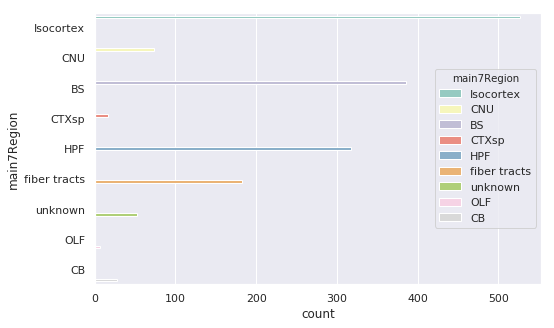

In [5]:
ct = somaRegDF["main7Region"].value_counts().sort_values(ascending=False)
thre = 0
sns.set(rc={'figure.figsize':(8,5)})
_ = sns.countplot(y="main7Region", 
                  data=somaRegDF.loc[somaRegDF.main7Region.isin(ct.index[ct>thre])],
                  hue = "main7Region", palette="Set3"
                 )


## 2.1.2) Projecting to three directions: "Horizontal","Coronal","Sagittal"

**2.1.2.1) By setting color="majorSOMA" in cell_in_map, the soma point will be shown with 7 major regions**
* Here set the 'Cluster' column in ns.metadata to be the region name.

**2.1.2.2) By setting color="soma" in cell_in_map, the soma point will be shown with 256 colors**
* No need to set the 'Cluster' column in ns.metadata to be the region name.

<blockquote>Example: Plot three views in a single plot with 256 color</blockquote>

```Python
    from neuro_morpho_toolbox.plot import cell_in_map
    fig, ax = plt.subplots(3,1, figsize=(7.5, 10))
    cur_list = ns.metadata.index.tolist()
    cell_in_map(ns.neurons, cur_list, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="soma",alpha=1,ax=ax[0])
    cell_in_map(ns.neurons, cur_list, ns.metadata,ccf_annotation=nmt.annotation, 
                view="Coronal", color="soma", alpha=1,ax=ax[1])
    cell_in_map(ns.neurons,cur_list, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Sagittal", color="soma", alpha=1, ax=ax[2])
    #fig.savefig('../Figure/Cell_in_map.pdf')
```

**2.1.2.1)  Plot singel view('Horizontal') with only 7 major regions**

Illustrating soma locations inside a brain from horizontal view:


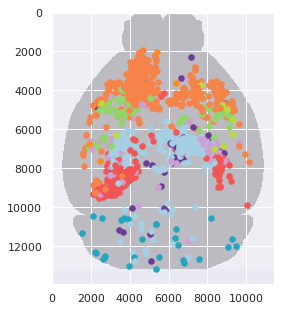

In [6]:
from neuro_morpho_toolbox.plot import cell_in_map
fig, ax =  plt.subplots(1,1)
cur_list = ns.metadata.index.tolist()
somaRegDF['Cluster']= somaRegDF.loc[:,'main7Region']
somaRegDF
cell_in_map(ns.neurons, cur_list, somaRegDF,ccf_annotation=nmt.annotation,view="Horizontal",color="majorsoma",ax=ax
           )
#fig.savefig('/home/penglab/FeaCal/horizonsaved')

**2.1.2.2) Plot singel view('Horizontal') with all regions**

Illustrating soma locations inside a brain from horizontal view:


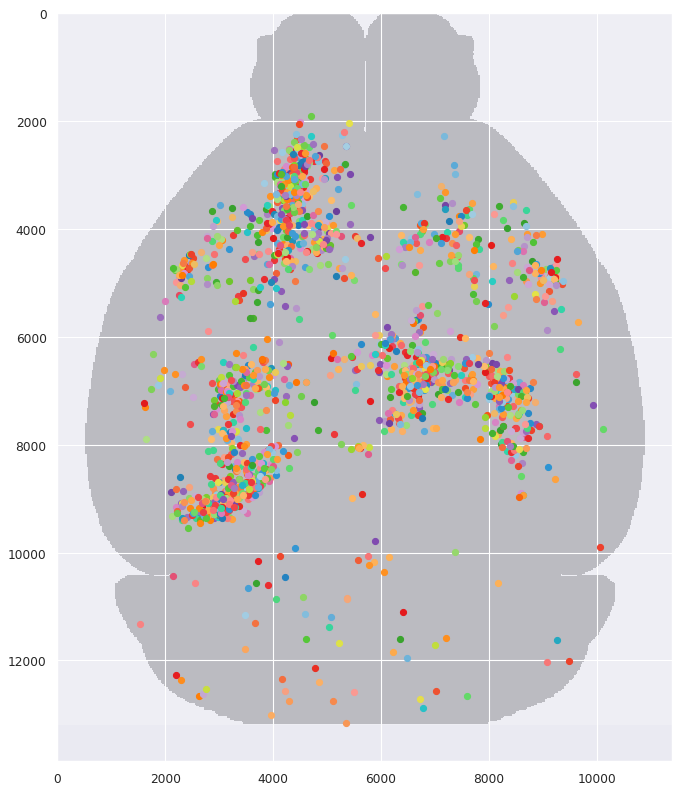

In [7]:
from neuro_morpho_toolbox.plot import cell_in_map
cur_list = ns.metadata.index.tolist()
somaRegDF
cell_in_map(ns.neurons, cur_list, ns.metadata,ccf_annotation=nmt.annotation,view="Horizontal", color="soma")
#fig.savefig('/home/penglab/FeaCal/horizonsaved')

## 2.1.3) Use wordcloud to illustrate the information
* Not going to write into the pkg just to show the result

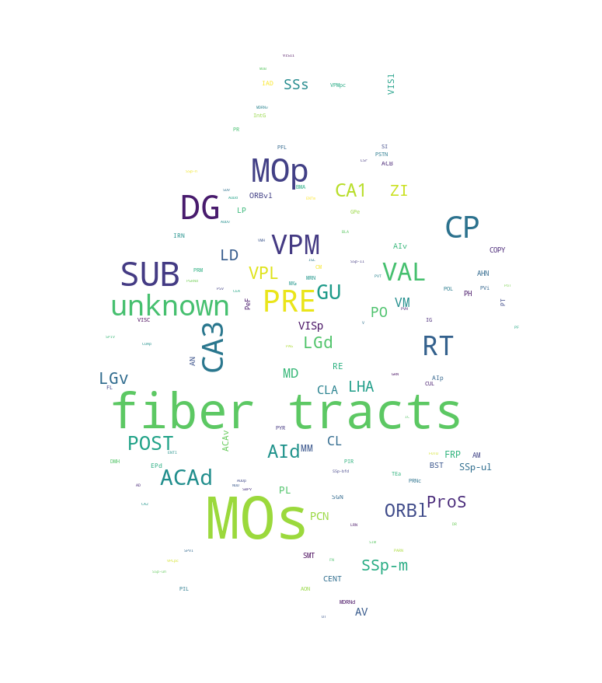

In [8]:
import jieba               
from wordcloud import WordCloud   
from PIL import Image
img = np.array(Image.open("/home/penglab/Desktop/mask.png"))
region_all, count = np.unique(somaRegDF['Region'], return_counts=True)
somaDIC = {}
for i in range(len(region_all)):
    #if region_all[i] == 'fiber tracts':
        #continue
    somaDIC[region_all[i]] = count[i]

wc = WordCloud(background_color='white',width=240,height=160,max_font_size=75,min_font_size=5,
               colormap="viridis", mask = img)
wc.generate_from_frequencies(somaDIC)
#save the file
wc.to_file('/home/penglab/Desktop/WC.png') 
# Show the plot
plt.figure(figsize=(10,20)) 
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()


## 1.1) Analyze soma location to obtain confident list

**Read the downsample-25 array with selected CCF region**

<blockquote>Example
    
```Python
nmt.ccfArray
```
</blockquote>

**Read the 6-nearest neighbor Contour Matrix with CCF index on**

* Originally, selected CCF has *316* regions, after using all the selected index to replace the child region, there are *337* regions.
* Therefore, there are 23 regions that show up in the nrrd array but have not been mentioned in the above selected CCF or its child region

<blockquote>Example
    
```Python
nmt.Contour01
```
</blockquote>

***Use nmt.disCal to obtain a DataFrame with columns ['x', 'y', 'z', 'SqEuclidean', 'min_Euclidean']***

<blockquote>Example
</blockquote>

```Python
    somaDis = nmt.disCal(ns.features['soma_features'].raw_data,
                         CCF_6_01,ccfArray, 10, flipF = True)
```


In [9]:
pickle_in = open("/home/penglab/NMTcode/somaDis.pickle","rb")
example_ = pickle.load(pickle_in)
somaDis = example_[0]

SelectedDF is obtained by throwing the unknown region and fiber tracts soma away

In [10]:
selectedDF = somaDis[somaDis['SqEuclidean'] != 'unknown'].copy()
selectedDF = selectedDF[selectedDF['Region'] != 'fiber tracts'].copy()
confi_list = selectedDF.index.tolist()
print('Number of confident neurons are '+ str(len(confi_list)))
se_list = selectedDF.index.tolist()

Number of confident neurons are 1006


## Calculate ARI according to a given list

### Generate the dataframe using pickCLUSTERpara(method)

<blockquote>Example</blockquote>

```Python
    hier_resultDF = ns.pickCLUSTERpara('hierarchy',se_list)
    kmeans_resultDF = ns.pickCLUSTERpara('kmeans',se_list)
    dbscan_resultDF = ns.pickCLUSTERpara('dbscan',se_list)
    hdbscan_resultDF = ns.pickCLUSTERpara('hdbscan',se_list)
    snn_resultDF = ns.pickCLUSTERpara('snn',se_list)
```
or if want to calculate ARI for all neurons, just use
```Python
    hier_resultDF = ns.pickCLUSTERpara('hierarchy')
    kmeans_resultDF = ns.pickCLUSTERpara('kmeans')
    dbscan_resultDF = ns.pickCLUSTERpara('dbscan')
    hdbscan_resultDF = ns.pickCLUSTERpara('hdbscan')
    snn_resultDF = ns.pickCLUSTERpara('snn')
```

### Print out the most proper parameter by maximizing ARI

<blockquote>Example</blockquote>

```Python
    hierbest = findBESTpara(hier_resultDF,[15,45],16)
    kmeansbest = findBESTpara(kmeans_resultDF,[15,45],16)
    dbscanbest = findBESTpara(dbscan_resultDF,[15,45],16)
    hdbscanbest = findBESTpara(hdbscan_resultDF,[15,45],16)
    snnbest = findBESTpara(snn_resultDF,[15,45],16)
```

## Using co-clustering towards the selected parameters

### Feature 1: projection patterns

In [11]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

In [12]:
AP_hierDF = pd.read_excel('/home/penglab/NMTcode/AP_hier_co_cluster.xlsx', index_col=0)
AP_kmeansDF = pd.read_excel('/home/penglab/NMTcode/AP_kmeans_co_cluster.xlsx', index_col=0)
AP_dbscanDF = pd.read_excel('/home/penglab/NMTcode/AP_dbscan_co_cluster.xlsx', index_col=0)
AP_hdbscanDF = pd.read_excel('/home/penglab/NMTcode/AP_hdbscan_co_cluster.xlsx', index_col=0)
AP_snnDF = pd.read_excel('/home/penglab/NMTcode/AP_snn_co_cluster.xlsx', index_col=0)

**Hierarchy**
* 0.19707750078003858
* 0.19008590059586536   Not specified

<blockquote>Example</blockquote>

```Python
  _ = ns.bestCoCluster(AP_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```


**Kmeans**
* 0.22447282585026812
* 0.23757234135967928   Not specified

<blockquote>Example</blockquote>

```Python
  _ = ns.bestCoCluster(AP_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```


**DBSCAN**
* 0.09026416477575772
* 0.09236174131638324   Not specified

<blockquote>Example</blockquote>

```Python
  _ = ns.bestCoCluster(AP_dbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
    
```


**HDBSCAN**
* 0.0472103345317394
* 0.08773477141372713   Not specified

<blockquote>Example</blockquote>

```Python
  _ = ns.bestCoCluster(AP_hdbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)

```


**SNN**
* 0.20760902962055355
* 0.2203302483933457   Not specified

<blockquote>Example</blockquote>

```Python
_ = ns.bestCoCluster(AP_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```


### Feature 2: Soma Location

In [13]:
SL_hierDF = pd.read_excel('/home/penglab/NMTcode/SL_hier_co_cluster.xlsx', index_col=0)
SL_kmeansDF = pd.read_excel('/home/penglab/NMTcode/SL_kmeans_co_cluster.xlsx', index_col=0)
SL_dbscanDF = pd.read_excel('/home/penglab/NMTcode/SL_dbscan_co_cluster.xlsx', index_col=0)
SL_hdbscanDF = pd.read_excel('/home/penglab/NMTcode/SL_hdbscan_co_cluster.xlsx', index_col=0)
SL_snnDF = pd.read_excel('/home/penglab/NMTcode/SL_snn_co_cluster.xlsx', index_col=0)

**Hierarchy**
* 0.12411518354928672
* 0.13524559251557391   Not specified

<blockquote>Example</blockquote>

```Python
_ = ns.bestCoCluster(SL_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)

```





**Kmeans**
* 0.1908960974370685
* 0.18858694643298865   Not specified


<blockquote>Example</blockquote>

```Python
_ = ns.bestCoCluster(SL_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```





**DBSCAN**
* 0.1519487699593167
* 0.11290188493510778   Not specified


<blockquote>Example</blockquote>

```Python
_ = ns.bestCoCluster(SL_dbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```






**HDBSCAN**
* 0.09636071813601153
* 0.08173723592554322   Not specified


<blockquote>Example</blockquote>

```Python
 = ns.bestCoCluster(SL_hdbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
    
```






_

**SNN**
* 0.17827195932588275
* 0.20654237679778586   Not specified


<blockquote>Example</blockquote>

```Python
 = ns.bestCoCluster(SL_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
    
```

## Illustrating clustering result

In [14]:
List_se = []
List_entire = []
def obtainARIlist(coclusterDF, t_range):
    i = 0
    for t_iter in t_range:
        i = i+1
        tempARI_se = ns.bestCoCluster(coclusterDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
        tempARI = ns.bestCoCluster(coclusterDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
        List_se.append(tempARI_se)
        List_entire.append(tempARI)
        print("Loading process: %.2f" % (i/len(t_range)))
    print('\n')
    return [List_se, List_entire]

In [57]:
pickle_in = open("/home/penglab/Desktop/AP_entire5.pickle","rb")
[AP_entire5] = pickle.load(pickle_in)
pickle_in = open("/home/penglab/Desktop/AP_se5.pickle","rb")
[AP_se5] = pickle.load(pickle_in)
pickle_in = open("/home/penglab/Desktop/SL_entire5.pickle","rb")
[SL_entire5] = pickle.load(pickle_in)
pickle_in = open("/home/penglab/Desktop/SL_se5.pickle","rb")
[SL_se5] = pickle.load(pickle_in)



In [58]:
### Create a dataframe to store the result
#前85*10 = 800个是AP，0-85是Hierarchy selected
# n 个AP se,n个AP entire  -HIER
# n 个AP se,n个AP entire  -KMEANS
# n 个AP se,n个AP entire  -DBSCAN
# n 个AP se,n个AP entire  -HDBSCAN
# n 个AP se,n个AP entire  -SNN

# 10n 个AP
import itertools
n = len(range(15,100))
ARI_DF = pd.DataFrame(columns = ['FeatureSet','numCluster','RegionUsed','Method','ARI'],index = range(20*n))
ARI_DF.loc[0:10*n,'FeatureSet'] = 'AP'
ARI_DF.loc[10*n:,'FeatureSet'] = 'SL'
L = list(itertools.repeat("selected", n))
for i in (list(itertools.repeat("Entire", n))):
    L.append(i)
ARI_DF.loc[:,'RegionUsed']= L*10
ARI_DF.loc[:,'numCluster']= np.tile(range(15,100), 20)
ARI_DF.loc[:,'Method']= [ele for ele in ['Hierarchy','Kmeans','DBSCAN','HDBSCAN','SNN'] for _ in range(2*n)]*2


ii = 0
for i in np.arange(0,10,2):
    ARI_DF.iloc[i*n:(i+1)*n,4] = AP_entire5[ii][:]
    ARI_DF.iloc[(i+1)*n:(i+2)*n,4] = AP_se5[ii][:]
    ii = ii+1
ii = 0
for i in np.arange(10,20,2):
    ARI_DF.iloc[i*n:(i+1)*n,4] = SL_entire5[ii][:]
    ARI_DF.iloc[(i+1)*n:(i+2)*n,4] = SL_se5[ii][:]
    ii = ii+1

In [61]:
ARI_DF[['numCluster', 'ARI']] = ARI_DF[['numCluster', 'ARI']].astype(float)

In [ ]:
ARI_DF[['numCluster', 'ARI']] = ARI_DF[['numCluster', 'ARI']].astype(float)

### Entire

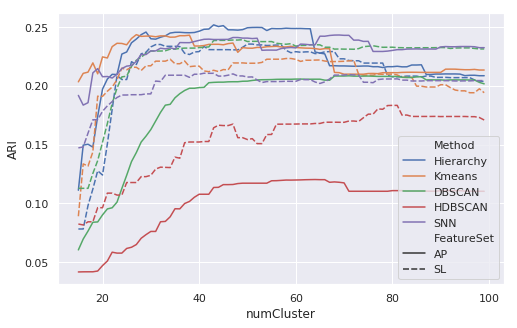

In [62]:
sns.lineplot(x="numCluster", y="ARI",style="FeatureSet", 
             hue="Method",        data=ARI_DF[ARI_DF['RegionUsed']=='Entire'])

### Selected

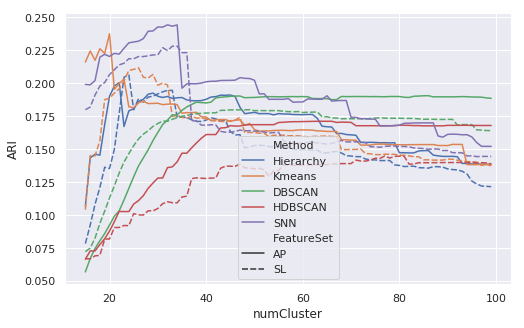

In [63]:
sns.lineplot(x="numCluster", y="ARI",style="FeatureSet", 
             hue="Method",        data=ARI_DF[ARI_DF['RegionUsed']=='selected'])

### Axon Projection Feature

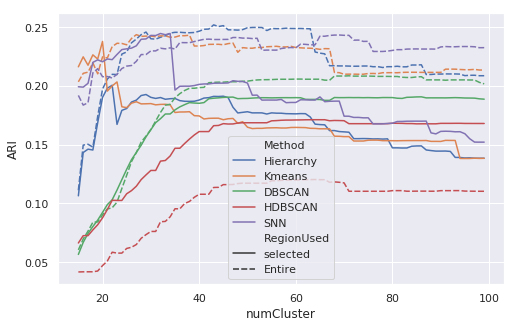

In [64]:
sns.lineplot(x="numCluster", y="ARI",style="RegionUsed", hue="Method", data=ARI_DF[ARI_DF['FeatureSet']=='AP'])

### Soma Location Feature

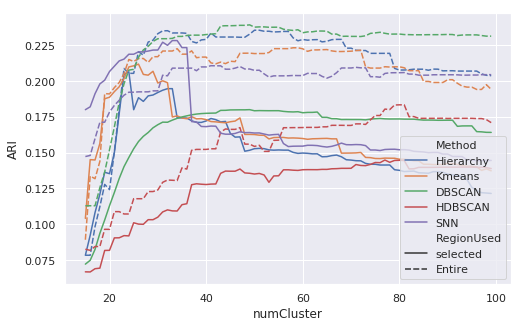

In [65]:
sns.lineplot(x="numCluster", y="ARI",style="RegionUsed", hue="Method", data=ARI_DF[ARI_DF['FeatureSet']=='SL'])

## Sum AP and SL together to see the result

In [68]:
Ahier_Shier = SL_hierDF + AP_hierDF
Ahier_Skmeans = SL_kmeansDF + AP_hierDF
Ahier_Sdbscan = SL_dbscanDF+ AP_hierDF
Ahier_Shdbscan = SL_hdbscanDF+ AP_hierDF
Ahier_Ssnn = SL_snnDF+ AP_hierDF

Akmeans_Shier = SL_hierDF + AP_kmeansDF
Akmeans_Skmeans = SL_kmeansDF + AP_kmeansDF
Akmeans_Sdbscan = SL_dbscanDF+ AP_kmeansDF
Akmeans_Shdbscan = SL_hdbscanDF+ AP_kmeansDF
Akmeans_Ssnn = SL_snnDF+ AP_kmeansDF

Adbscan_Shier = SL_hierDF + AP_dbscanDF
Adbscan_Skmeans = SL_kmeansDF + AP_dbscanDF
Adbscan_Sdbscan = SL_dbscanDF+ AP_dbscanDF
Adbscan_Shdbscan = SL_hdbscanDF+ AP_dbscanDF
Adbscan_Ssnn = SL_snnDF+ AP_dbscanDF

Ahdbscan_Shier = SL_hierDF + AP_hdbscanDF
Ahdbscan_Skmeans = SL_kmeansDF + AP_hdbscanDF
Ahdbscan_Sdbscan = SL_dbscanDF+ AP_hdbscanDF
Ahdbscan_Shdbscan = SL_hdbscanDF+ AP_hdbscanDF
Ahdbscan_Ssnn = SL_snnDF+ AP_hdbscanDF

Asnn_Shier = SL_hierDF + AP_snnDF
Asnn_Skmeans = SL_kmeansDF + AP_snnDF
Asnn_Sdbscan = SL_dbscanDF+ AP_snnDF
Asnn_Shdbscan = SL_hdbscanDF+ AP_snnDF
Asnn_Ssnn = SL_snnDF+ AP_snnDF

In [87]:
ARI_sumDF

,INPUTnum,RegionUsed,REALnum,AP,SL,ARI
0,15,selected,15,Hierarchy,Hierarchy,15
1,15,Entire,15,Hierarchy,Hierarchy,NaN
2,16,selected,16,Hierarchy,Hierarchy,16
3,16,Entire,16,Hierarchy,Hierarchy,NaN
4,17,selected,17,Hierarchy,Hierarchy,17
5,17,Entire,17,Hierarchy,Hierarchy,NaN
6,18,selected,18,Hierarchy,Hierarchy,18
7,18,Entire,18,Hierarchy,Hierarchy,NaN
8,19,selected,19,Hierarchy,Hierarchy,19
9,19,Entire,19,Hierarchy,Hierarchy,NaN


In [88]:
tempARI

0.19512316354788928

* ARI_sumDF has columns ['INPUTnum','REALnum', 'AP','SL','ARI']

In [89]:
import itertools
#85 * 2 * 25  = 4250
n = len(range(15,100))
ARI_sumDF = pd.DataFrame(columns =  ['INPUTnum','RegionUsed', 'REALnum', 'AP','SL','ARI'],index = range(2*25*n))

ARI_sumDF.loc[:,'INPUTnum']= np.tile(np.repeat(range(15,100),2), 25)
ARI_sumDF.loc[:,'AP']= [ele for ele in ['Hierarchy','Kmeans','DBSCAN','HDBSCAN','SNN'] for _ in range(10*n)]
ARI_sumDF.loc[:,'SL']= [ele for ele in ['Hierarchy','Kmeans','DBSCAN','HDBSCAN','SNN'] for _ in range(2*n)]*5


ARI_sumDF.loc[:,'RegionUsed']= ['selected' ,'Entire']*n*25


In [92]:
ii = 0
t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Ahier_Shier, nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Ahier_Shier, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Ahier_Skmeans, nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Ahier_Skmeans, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Ahier_Sdbscan, nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Ahier_Sdbscan, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

0.13858922792572553
0.1522345063626506
0.1907807587876119
0.19611191365586111
0.23455981598752132
0.22613201590157614
0.23455981598752132
0.19905476966463662
0.24737718591648777
0.20626746271522484
0.24290607474996748
0.2033394287432912
0.245423805491766
0.19723217855603312
0.24557231839620847
0.1910963885847388
0.2525863464457361
0.19658942021687373
0.2525863464457361
0.1944274570802026
0.2531750825579318
0.19512316354788928
0.25529820820742904
0.19682372808306922
0.2522842237042374
0.19456052283486583
0.2572209636486154
0.19804886134876612
0.25491762652604566
0.19740434299698645
0.24955952276906718
0.19691819451774736
0.25281137528787967
0.1978989793420624
0.25322096632107055
0.19987836445696103
0.25540195473320815
0.2004011294057045
0.2567173059476135
0.20085001705583122
0.25746413478448676
0.20111944592326925
0.257873743215622
0.20133901197627282
0.2581619590427797
0.20162514990182287
0.2582707419261651
0.2018458581214649
0.2594013239977979
0.20296970035655545
0.25550746110852
0.20

0.1411196696143674
0.21761370104212396
0.14008017729239816
0.21761370104212396
0.14019001428252728
0.21754533308010546
0.14015808668422536
0.21869699331183126
0.13583855813893278
0.2199560370040812
0.13634316077295658
0.21976529270928705
0.1366184588404416
0.21976529270928705
0.13693170291897558
0.22074925511575458
0.13730943824560676
0.22090830048483057
0.13740014806787157
0.22100381210783168
0.13769359846835932
0.22322868374448882
0.1391264457145319
0.22275148179561513
0.13895617483040956
0.22267933788810987
0.13894835227218535
0.2238986393202437
0.13951425127892095
0.21971507226930578
0.13801684815037008
0.21639833413427567
0.1366975224724057
0.2192119999750439
0.13745093037892145
0.2192119999750439
0.13595161327167105
0.2201843038937225
0.13549749452994359
0.2201843038937225
0.13520510615931114
0.2218975005602204
0.1358324375337876
0.2220270929896326
0.1361290096243373
0.2222141053722727
0.1362220933702084
0.22311552463323467
0.13654318117195907
0.22311552463323467
0.12840695065624

In [93]:
t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Ahier_Shdbscan, nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Ahier_Shdbscan , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Ahier_Ssnn, nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Ahier_Ssnn, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Akmeans_Shier , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Akmeans_Shier , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

0.11580375051479834
0.10658867605899382
0.11512827743478514
0.1071424469213455
0.1381631773405713
0.1262971988430161
0.16613860979028774
0.14659761443633168
0.16613860979028774
0.13014419871734811
0.16613860979028774
0.1295709145691968
0.16760376697177584
0.12932934202332813
0.17226801636994166
0.13480607248470328
0.1724182357440277
0.1349778091399069
0.17266733357970948
0.13029400361167554
0.17266733357970948
0.13007746789207475
0.17229207768459953
0.13005317187220056
0.17956416763248895
0.13365367149880028
0.1858259504195078
0.1382889879052459
0.1897869646939467
0.14180633958353026
0.1897869646939467
0.14251305594442443
0.19304405897843252
0.14405450948069976
0.1964104156446731
0.14556920429817735
0.1964104156446731
0.13786937315212025
0.1964104156446731
0.13579271577016505
0.202723464554483
0.1391599385864668
0.20145037519654235
0.1390520661842854
0.2026698042530038
0.13952678818649933
0.20750789559248523
0.141579082736823
0.20688495669464288
0.14137484366714945
0.2144543187018401
0

0.18848218538188888
0.26774605190264067
0.1879422704491719
0.26774605190264067
0.1788350963436608
0.26675848442990246
0.178449884074984
0.2622179623247862
0.17694117491551659
0.26051987772783103
0.1747223166447446
0.2621508586376672
0.17603907305392977
0.2630427300954398
0.17644881012687144
0.26381960339358435
0.17681125771569048
0.26381960339358435
0.17234027609761346
0.26381960339358435
0.16936890463231166
0.26615183183897034
0.17015968038128854
0.2692663504647441
0.17099591696576522
0.2692663504647441
0.17118126355916521
0.26997572687858085
0.17134388350705684
0.26997572687858085
0.17123379192993698
0.271243960933721
0.17154310937058295
0.2722489245708958
0.1718392656411838
0.26533846731554567
0.16717188386683707
0.26590734654301473
0.16737520074026763
0.2416968517810536
0.16021732850670062
0.24176890673177298
0.16025468007466678
0.24176890673177298
0.16016811418957408
0.24272364771595833
0.16043198483017246
0.24272364771595833
0.15215313220245205
0.24276513038998077
0.1521687908707

In [94]:
t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Akmeans_Skmeans, nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Akmeans_Skmeans , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Akmeans_Sdbscan , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Akmeans_Sdbscan , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Akmeans_Shdbscan , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Akmeans_Shdbscan , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

0.20630133745451157
0.22654058785342568
0.2277501889499649
0.2447444504668497
0.2320777133681521
0.2511502275710087
0.23214382677390732
0.20836181239569176
0.23138043593219196
0.20878721550138885
0.23254909124021347
0.20109558786593873
0.23568613524891566
0.199973367092614
0.24470036341070642
0.207046955420389
0.23723012126550175
0.2026199892591858
0.24385574836404514
0.2053710846470208
0.2453254765728482
0.20674592565329705
0.2453254765728482
0.1894305823196921
0.24926777396867345
0.19136414171635766
0.2500566793043692
0.19189021336628023
0.2506056617838386
0.18542741744883412
0.24977425206341672
0.1853424824387427
0.24977425206341672
0.18529119562270221
0.24977425206341672
0.1785042120925297
0.2539292776086871
0.17941206411631425
0.26159744889115444
0.18209145322513723
0.2639688813807188
0.1844822388229987
0.2596320780786136
0.18239614298213064
0.2612770049403879
0.18290829593263933
0.26003142680314995
0.18252029909211515
0.2577470254546713
0.18174362042794504
0.25865966187305783
0.1

0.1525450433973112
0.23798689153741798
0.14675577150319358
0.23936763570834382
0.14706540404988647
0.23928050697931552
0.14711914812956675
0.23928050697931552
0.1474963862297223
0.24572528343528796
0.14866346983094766
0.2474272411243562
0.1493249912276413
0.2474272411243562
0.1494866655812621
0.24841078596190286
0.1505138912251801
0.2485309420694598
0.15055033002146875
0.2503641048963977
0.15118086904781067
0.25047950979258726
0.15126836442302818
0.25047950979258726
0.14980187946088047
0.2509697257207694
0.15000612535961516
0.25064955538359324
0.1498920171008283
0.25064955538359324
0.14546292448125084
0.2510839432814376
0.14556105011811976
0.2580806923527211
0.1479316325490706
0.25891801485552807
0.14816453362574045
0.2591137743762291
0.1463471898753256
0.2604912156439002
0.14669011728917145
0.2613684581000093
0.1469074860849209
0.26144458646445606
0.14716257692978751
0.2605561747163392
0.14663670301698103
0.2605561747163392
0.1465371372776711
0.2606707220741299
0.14661200009893338
0.2

In [95]:
t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Akmeans_Ssnn, nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Akmeans_Ssnn , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Adbscan_Shier , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Adbscan_Shier , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Adbscan_Skmeans , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Adbscan_Skmeans , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

0.14465531758292463
0.19528644212406393
0.14701998349157852
0.19719300197659373
0.15154351554829457
0.2029171207719517
0.17569001589213765
0.2188561726580185
0.17795936779182023
0.22110996572449182
0.17806415724883992
0.21053224570985457
0.17844611806515398
0.21100252638767145
0.18912049246270465
0.21755346907393777
0.18917471787247345
0.21233121283888354
0.19356659956385955
0.2154499060843412
0.19356659956385955
0.18140093816590383
0.19356659956385955
0.17555798541167517
0.19356659956385955
0.1737179731788796
0.19362297675043
0.17392359356757145
0.19679717949462316
0.17383677710264323
0.19817700463300755
0.17504434476977204
0.1983803261301021
0.1756887797984411
0.19976523880173652
0.1763173145969316
0.21137320162562195
0.18123943108445628
0.21167762014558986
0.18139292308404745
0.21582499156736926
0.18341237320518294
0.21582499156736926
0.16552062985789276
0.21975377309255828
0.16715223642127386
0.22345026461610093
0.1683794694985051
0.22318172726322813
0.16843959356481447
0.223181727

0.16084829420221589
0.20567031904924038
0.16116460061788312
0.2036450638899328
0.16092139256116494
0.2036450638899328
0.15017540874757856
0.2055122032853084
0.1507136683517016
0.20561041910159747
0.15022661620966432
0.20561041910159747
0.15011135535592268
0.20561041910159747
0.14804257090300496
0.20561041910159747
0.14822455956903327
0.2069230188663785
0.1489302032174513
0.20519122673713955
0.14826642394160736
0.20541943341344868
0.1415422864082073
0.20100725622342372
0.14001655173363062
0.20477824198735464
0.14163929071430092
0.20477824198735464
0.1422089471109365
0.20238343880041734
0.1410617489396456
0.20246217947217798
0.14109119864422065
0.20240170545406
0.14108714578548118
0.20257517987256407
0.13869901401288212
0.20928847155303418
0.14188043773877762
0.20977443736729515
0.1419968526277402
0.20977443736729515
0.13234546951023182
0.20977443736729515
0.1310119432273011
0.20977443736729515
0.12967979989166825
0.21048701846716913
0.132172095233762
0.21068888243899578
0.13237547794819

In [96]:
t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Adbscan_Sdbscan, nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Adbscan_Sdbscan , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Adbscan_Shdbscan  , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Adbscan_Shdbscan  , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Adbscan_Ssnn , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Adbscan_Ssnn , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

0.10488841646382815
0.0986868745385635
0.10488841646382815
0.09384609093785568
0.10488841646382815
0.0931302309382137
0.10569964028438836
0.09329225656047149
0.11535971121374688
0.10808830792108505
0.1131203270240369
0.10795985733323679
0.1131203270240369
0.10717000267694753
0.12475153884884628
0.1112841224971483
0.13158673816594982
0.11572505187461275
0.1343491758901595
0.11691818189173309
0.13346017280229786
0.11679504261380048
0.1342478253536574
0.12504384728391904
0.13561392171229658
0.1261950368437045
0.15095040482868669
0.13798122182470124
0.14901220111836982
0.13790610947766366
0.14533723368866686
0.13635340455640518
0.14715160319462575
0.13781191206934634
0.147379893554925
0.13853794875821804
0.14763524335798178
0.13870526631930136
0.14763524335798178
0.13865660481862457
0.15348607775628192
0.14217586425028544
0.15348607775628192
0.1409831032790658
0.15348607775628192
0.12150420449133974
0.15348607775628192
0.12431045545183501
0.15348607775628192
0.11451434300462844
0.159450919

0.18186134017446484
0.12957415645636366
0.18411325950877694
0.12954373880838327
0.18411325950877694
0.12964987379515477
0.18475084518641535
0.1306137213539288
0.18461352094820782
0.1305617253593893
0.18461352094820782
0.13045022741700085
0.18486585283536447
0.1305379378932197
0.18703127846124581
0.13271581048043404
0.17436910980541095
0.1271833902775758
0.1757652020288841
0.12785691650801553
0.17877466863185287
0.12905866767682445
0.1788483289877646
0.12933078539490891
0.1793713939890146
0.12958861747788786
0.17997902900492518
0.13009869489379414
0.18009890691250854
0.13019861271242247
0.18041139266584447
0.13030915516598193
0.18041139266584447
0.12979464204561741
0.18291443217378428
0.13082171252767533
0.18375739464063215
0.13107577135342963
0.18375739464063215
0.13097028053035248
0.18382023627311206
0.1309893881038964
0.18384372046865238
0.1309980735941205
0.1869407270559954
0.13213645735628654
0.1862293521602002
0.13191707646656717
0.1862293521602002
0.12809790113771455
0.1861825189

In [98]:
t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Ahdbscan_Shier , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Ahdbscan_Shier  , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Ahdbscan_Skmeans  , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Ahdbscan_Skmeans  , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Ahdbscan_Sdbscan , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Ahdbscan_Sdbscan , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

0.08495080410373419
0.1288263031259749
0.09263550053727727
0.13739056959915738
0.09263550053727727
0.1337309805229519
0.09720017916548016
0.13965389381090143
0.09514437528403924
0.13949570951901166
0.09514437528403924
0.13708672422183057
0.09517511675499392
0.13712701421188328
0.10094137570966767
0.14276926124570835
0.10267267748587935
0.14666803083610366
0.10800655475385951
0.15031447042811416
0.12132029133346676
0.16118785114366393
0.12392553462180164
0.16306746677018144
0.12392553462180164
0.16187122390109154
0.12392553462180164
0.1616409477829228
0.12052981295544343
0.16040727466179378
0.11729511984168481
0.160739656657454
0.1255385782616312
0.17203597871834886
0.1221090645615366
0.17147044963027386
0.12476554160382981
0.1734719738798841
0.12476554160382981
0.17538863577699793
0.12490931762244747
0.17548645061050372
0.12490931762244747
0.17549596045981722
0.13168399561142752
0.1815927814334571
0.13402088870358683
0.1836077798907726
0.13403302518015275
0.1836155113683443
0.134033025

0.1559439554355025
0.12109316437412003
0.15533751035411666
0.12082769681070442
0.1579078518400399
0.12221688641708572
0.1579078518400399
0.1220847089435288
0.14705515012581094
0.11882814159378524
0.14705515012581094
0.09614179479894895
0.15285397126963432
0.09901570042858754
0.1530599902523405
0.09912394550228369
0.16217986193332712
0.10370083291586046
0.16152947906447476
0.10383839471208305
0.16280031679594834
0.10457187616202218
0.16223936662424668
0.10442050662510788
0.16223936662424668
0.10443386164460942
0.16216528454928486
0.10368420655817813
0.1624393952169089
0.1037648003016689
0.16241889723510902
0.10348141567831826
0.1605819445196445
0.10291177583123912
0.16696174892960772
0.10629250553833676
0.1673362874756276
0.10475503970003112
0.16767069993770872
0.10509119090533256
0.16777326194439365
0.10534096249181386
0.1683383896874892
0.10584684185428268
0.1683522252296318
0.10585084587943548
0.1732496309666484
0.10932738620459297
0.17367617233824392
0.10950491438117595
0.1730277242

In [117]:
510/3

170.0

In [118]:
2552+510-1

3061

In [99]:
t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Ahdbscan_Shdbscan  , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Ahdbscan_Shdbscan  , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Ahdbscan_Ssnn , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Ahdbscan_Ssnn , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Asnn_Shier , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Asnn_Shier , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

0.05636350239725562
0.054618670453994767
0.05636350239725562
0.05531692242329822
0.06525598064295507
0.06832534186194987
0.06525598064295507
0.06832534186194987
0.06525598064295507
0.06832534186194987
0.07276321467404022
0.07798411703516622
0.07718542984763489
0.08259910872930405
0.07722601644523258
0.07358464149374833
0.0773331337683896
0.07049017651777373
0.08203461458894903
0.08077904352167099
0.08203461458894903
0.06441716096544649
0.08203461458894903
0.059153061195602735
0.09112119282593147
0.06835334066127542
0.09112119282593147
0.06839417227815521
0.09116215527546943
0.0683438461369733
0.09223209919131631
0.06896317020476132
0.09384531919967903
0.06999203675490043
0.09373867173822789
0.07012071542154515
0.09562757830332269
0.07302910381350518
0.09562757830332269
0.07329966123573868
0.09582369931454283
0.07360218474559581
0.09932323660582285
0.07670432084525912
0.09932554579498024
0.07681812129518831
0.09932554579498024
0.07706316847519087
0.1058810046624735
0.08392126127376372
0

0.24589567101542356
0.18502938116080164
0.2536858925505625
0.18809869305605958
0.25442335834437685
0.1886360652566491
0.2552862404020905
0.18897019028263376
0.2552862404020905
0.18859678543115482
0.256010607088914
0.1888575649417171
0.2578466909636882
0.18938099662900362
0.25689734058866887
0.18945947028071777
0.2579950448356682
0.18974658428263763
0.2577723451507184
0.19073288627725662
0.25454316200777566
0.18996878207261095
0.25454316200777566
0.19025379438127427
0.25718251580800705
0.19098193726436802
0.2570748003162402
0.19095477882874862
0.25378516473210133
0.18997203162752702
0.2543437091344856
0.19024799034468107
0.2543437091344856
0.18103820235852705
0.25465205791721907
0.18120806856540522
0.25465205791721907
0.1815628273477947
0.25465205791721907
0.17451536620336291
0.25517300890623384
0.17464448246684902
0.25730390224016925
0.17527884754903633
0.2575083152310921
0.17534677829556838
0.2575083152310921
0.17546641008148992
0.2576925073297808
0.17553330142527077
0.257938422240195

In [100]:
t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Asnn_Skmeans  , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Asnn_Skmeans , nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Asnn_Sdbscan , nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Asnn_Sdbscan, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Asnn_Shdbscan, nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Asnn_Shdbscan, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

t_iter = 15
for i in np.arange(ii*(n*2),n*2*(ii+1),2):
    tempARI_se = ns.bestCoCluster(Asnn_Ssnn, nmt.get_group_colors(ns.metadata, group_by="CellType", 
                                                                    palette="paired", return_str = True,
                                                                    return_hex = True), t = t_iter,
                                                                  selected_list= se_list)
    ARI_sumDF.loc[i,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i,'ARI'] = tempARI_se
    tempARI = ns.bestCoCluster(Asnn_Ssnn, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    ARI_sumDF.loc[i+1,'REALnum'] = len(ns.metadata['Cluster'].unique())
    ARI_sumDF.loc[i+1,'ARI'] = tempARI
    t_iter = t_iter + 1
ii = ii+1

0.19415975241070543
0.2175016529204344
0.19583277416868303
0.21146857311200126
0.19888349716646028
0.21451647022638407
0.19888349716646028
0.21481547610697155
0.20040102469066506
0.21586663433941625
0.20125380878484214
0.2163445224418936
0.2066235761409475
0.22229795979611586
0.23400266599670153
0.24090939930651784
0.23584674714187667
0.24309924743339972
0.24787618078596432
0.24968135250957796
0.23624187558933174
0.24585060603488804
0.22857429901706935
0.2436032450323096
0.22857429901706935
0.1981880952374877
0.22874209983354246
0.19843951452804126
0.22874209983354246
0.19849328054711496
0.22829408255137773
0.19879367876250745
0.22857931115299582
0.19877420221635983
0.22897426998186127
0.19286501112794155
0.22940377384516178
0.19320932590519235
0.23819548822947584
0.2007233276115959
0.23873201161335744
0.200983402531435
0.23908640674455706
0.20160958768194895
0.23850857706612716
0.20123576273684707
0.23850857706612716
0.2011561003888529
0.23853703579370353
0.20137232200135538
0.2389108

0.14949158458059325
0.23756772552738933
0.14892662605860602
0.23756772552738933
0.14881461488836906
0.2370806546095305
0.14865840624262786
0.2370806546095305
0.14639634304891924
0.23935950195631708
0.14771829917144763
0.2426469915134249
0.1490761443934364
0.24266352063504967
0.14921892723840696
0.24276927874842535
0.14923128087798201
0.2433177211830809
0.14723661823395415
0.24332799056571372
0.1470338983002918
0.24342553418150423
0.146996433016616
0.24257359074819485
0.146981916886864
0.24284280000655528
0.14705830210463625
0.24336996176144643
0.14774532724331116
0.24336996176144643
0.14764618012873962
0.24221751209045964
0.14727354225402256
0.24333699388550142
0.1476022133603281
0.24301561673213196
0.14747812022553336
0.2448087887063915
0.14799014973348645
0.24487834965829094
0.14801927475296203
0.24497373159763752
0.14802015940263705
0.2497865811172883
0.14976593209202413
0.24971921226052934
0.14969279447216255
0.24971921226052934
0.14798479241171877
0.24977692975036145
0.14801382875

In [113]:
85*2*25

4250

In [112]:
 np.tile(np.repeat(range(15,100),2), 25)

array([15, 15, 16, ..., 98, 99, 99])

In [114]:
ARI_sumDF.to_excel('/home/penglab/Desktop/ARI_sumDF.xlsx')

In [106]:
ARI_sumDF

,INPUTnum,RegionUsed,REALnum,AP,SL,ARI
0,15.0,selected,15.0,Hierarchy,Hierarchy,0.138589
1,15.0,Entire,15.0,Hierarchy,Hierarchy,0.152235
2,16.0,selected,16.0,Hierarchy,Hierarchy,0.190781
3,16.0,Entire,16.0,Hierarchy,Hierarchy,0.196112
4,17.0,selected,17.0,Hierarchy,Hierarchy,0.234560
5,17.0,Entire,17.0,Hierarchy,Hierarchy,0.226132
6,18.0,selected,18.0,Hierarchy,Hierarchy,0.234560
7,18.0,Entire,18.0,Hierarchy,Hierarchy,0.199055
8,19.0,selected,19.0,Hierarchy,Hierarchy,0.247377
9,19.0,Entire,19.0,Hierarchy,Hierarchy,0.206267


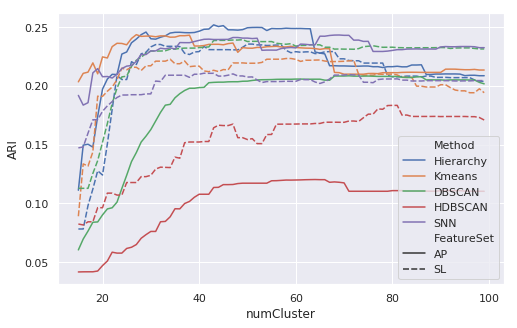

In [101]:
sns.lineplot(x="numCluster", y="ARI",style="FeatureSet", 
             hue="Method",        data=ARI_DF[ARI_DF['RegionUsed']=='Entire'])

## Feature 3: axon morphological features

In [ ]:
# 1. Axon overall
df1 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df1.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df1 = df1[use_cols]

feature_name = use_cols
new_feature_name = ['A_'+i.replace(' ', '_') for i in use_cols]
df1.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)


In [ ]:
# 2. Local axon
df2 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df2.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df2 = df2[use_cols]

feature_name = use_cols
new_feature_name = ['AL_'+i.replace(' ', '_') for i in use_cols]
df2.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

In [ ]:
df = pd.concat([df1, df2], axis=1)
lm_axon = nmt.features("L-measure of axon")
lm_axon.add_raw_data(df)

pickle.dump([lm_axon], open("features_lm_axon.pickle", "wb"))

## Feature 4: dendrite morphological features

In [ ]:
df = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df = df[use_cols]

feature_name = use_cols
new_feature_name = ['D_'+i.replace(' ', '_') for i in use_cols]
df.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

lm_dendrite = nmt.features("L-measure of dendrite")
lm_dendrite.add_raw_data(df)

pickle.dump([lm_dendrite], open("features_lm_dendrite.pickle", "wb"))

In [ ]:
print(np.log(10000), np.log(5000))